In [3]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

%matplotlib inline

### <p style="text-align: center; color: green;">Motion Estimation Node based</p>  

#### We are going to show the motion estimation between two images with the node based method seen in class.

Let's recreate the Image class.

In [4]:
class Image:

    def __init__(self, pathImg):
        self.img = cv2.imread(pathImg)
        self.grayImage = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.height, self.width = self.grayImage.shape[:2]

Let's see what the two images look like so that we have a better idea of the motion from the first image to the second one.

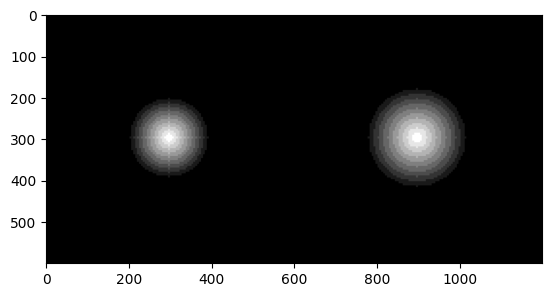

In [5]:
# create a new figure
fig, ax = plt.subplots()

# Charger les deux images
img1 = Image('1.png')
img2 = Image('2.png')

ax.clear()
# Show the two images side by side
ax.imshow(np.hstack((img1.grayImage, img2.grayImage)), cmap='gray')
plt.show()


Now, we are going to define constants for splitting the image and the iteration step for the pixels.

In [6]:
BLOCK_LEN = img1.grayImage.shape[0] // 4
STEP = 4

Let's also define useful methods and variables for the next parts.

In [7]:
# Define the colors of the rectangles
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'white']

# function returning the coordinates of the blocks from the image
def getBlocksCoordinates(img):
    blocksCoordinates = []
    len = img.shape[0] // BLOCK_LEN
    for i in range(len):
        for j in range(len):
            blocksCoordinates.append([[i*BLOCK_LEN, j*BLOCK_LEN], [(i+1)*BLOCK_LEN, j*BLOCK_LEN], [(i+1)*BLOCK_LEN, (j+1)*BLOCK_LEN], [i*BLOCK_LEN, (j+1)*BLOCK_LEN]])
    return blocksCoordinates

# function getting the all the coordinates inside of a block knowing its up left corner coordinates and its length
def getBlockPixels(corners):
    array = []
    for i in range(corners[0][0], corners[2][0], STEP):
        for j in range(corners[0][1], corners[2][1], STEP):
            array.append([i, j])
    return array

To apply the method, we will need to separate each block into polygon shapes with different colors and then apply onto their four corners the estimated motion. Here is an example of all nodes without their displacements.

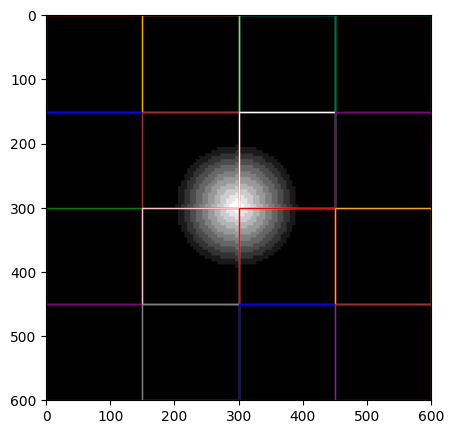

In [8]:
# Create a figure and axis object
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.imshow(img1.grayImage, cmap='gray')

# Get the coordinates of the blocks of the first image and plot the rectangles
rect_coords = getBlocksCoordinates(img1.grayImage)

# Plot the polygons
for i in range(len(rect_coords)):
    rect = plt.Polygon(rect_coords[i], fill=False, edgecolor=colors[i % len(colors)])
    ax.add_patch(rect)

# Set the limits of the plot
ax.set_xlim(0, img1.width)
ax.set_ylim(img1.height, 0)

plt.show()

Now let's get into it and apply the method seen in class.  
For that we will use a regularization technique. This technique will be used via lambdas.

In [9]:
def getInterpolation(corners):
    list_x = [corners[0][0], corners[1][0], corners[2][0], corners[3][0]]
    list_y = [corners[0][1], corners[1][1], corners[2][1], corners[3][1]]

    xmax, xmin, ymax, ymin = max(list_x), min(list_x), max(list_y), min(list_y)
    constant = (xmax-xmin)*(ymax-ymin)

    phi1 = lambda x,y : (xmax-x)*(ymax-y)/constant
    phi2 = lambda x,y : (x-xmin)*(ymax-y)/constant
    phi3 = lambda x,y : (x-xmin)*(y-ymin)/constant
    phi4 = lambda x,y : (xmax-x)*(y-ymin)/constant

    return phi1, phi2, phi3, phi4

def getDisplacement(corners, vectors):
    phi1, phi2, phi3, phi4 = getInterpolation(corners)
    sum = lambda x,y : phi1(x,y) * vectors[0] + phi2(x,y) * vectors[1] + phi3(x,y) * vectors[2] + phi4(x,y) * vectors[3]
    return sum

Here we define the method used to compute the sum of intensities (energy) throughout the block with a specific regularization (d).

In [10]:
# function getting the intensity of a point in an image
def getIntensity(img, coordinate):
    return img[int(coordinate[0]), int(coordinate[1])]

# function computing the sum of quadratic displacement in a node between two images
def computeEnergyBlock(img1, img2, block, d):
    EDFD = 0
    for coordinate in getBlockPixels(block):
        newCoordinate = coordinate + d(coordinate[0], coordinate[1])

        newCoordinate[0] = max(0, min(int(newCoordinate[0]), img1.shape[0]-1))
        newCoordinate[1] = max(0, min(int(newCoordinate[1]), img1.shape[1]-1))

        I2 = getIntensity(img2, newCoordinate)
        I1 = getIntensity(img1, coordinate)
        if I2 < I1:
            EDFD += (I1 - I2) ** 2
        else:
            EDFD += (I2 - I1) ** 2
    return EDFD

Finally, this method will apply the gradient descent on the four corners of each block and return the estimated corners of each block.

In [11]:
# function iterating through all blocks of an image, computing the gradient descent of each block and returning a list of all the vectors
def getNodesDisplacement(img1, img2, learningRate=1e-4, nbEpochs=15, h=2):
    blocks = getBlocksCoordinates(img1)
    vectors = np.zeros((len(blocks), 4, 2))
    
    for epoch in range(nbEpochs):
        print("Epoch:", epoch + 1)
        for indNode, block in enumerate(blocks):
            vector = vectors[indNode]
            d = getDisplacement(block, vector)
            energy = computeEnergyBlock(img1, img2, block, d)

            tmp_vector = copy.deepcopy(vector)
            for i, vect in enumerate(vector):
                for axis in range(2):
                    copyVector = copy.deepcopy(tmp_vector)
                    copyVector[i][axis] += h
                    
                    d = getDisplacement(block, copyVector)
                    newEnergy = computeEnergyBlock(img1, img2, block, d)
                    vect[axis] -= learningRate * (newEnergy - energy) / h

    return blocks + vectors

Let's show the result of the estimation when calling `getNodesDisplacement` on the two images we have.

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15


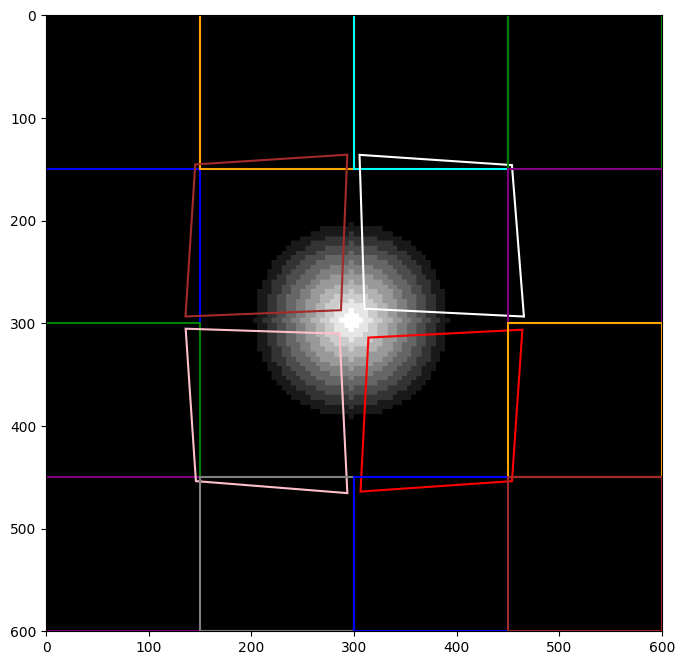

In [12]:
allNodes = getNodesDisplacement(img1.grayImage, img2.grayImage)

# Create a figure and axis object
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img1.grayImage, cmap='gray')

# Plot the polygons
for i in range(len(allNodes)):
    node = plt.Polygon(allNodes[i], fill=False, edgecolor=colors[i % len(colors)], linewidth=1.5)
    ax.add_patch(node)

# Set the limits of the plot
ax.set_xlim(0, img1.width)
ax.set_ylim(img1.height, 0)

plt.show()

Thanks to the polygons we can clearly see an uniform movement emanating from the center towards the side.